<a href="https://colab.research.google.com/github/avishek-astra/Deep-Learning-Projects/blob/main/predicting_heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [545]:
##importing libraries
#for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

#for number_crunching
import numpy as  np
#for dataset management
import pandas as pd
#for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')


Import and process the data

In [546]:
#import the data
url='https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
data=pd.read_csv(url,sep=',',header=None)
data.columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']

#data contains so(me/'s ;replace eith NaN and drop these rows
data=data.replace('?',np.nan).dropna()
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,DISEASE
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3


In [547]:
#describe the data
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,DISEASE
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


<ipython-input-548-56e8fa41b6ac>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


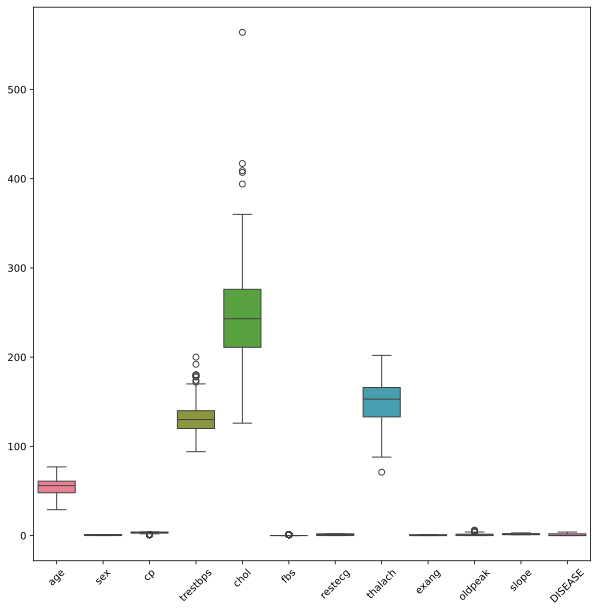

In [548]:
#check the distributions
fig,ax=plt.subplots(1,figsize=(10,10))
ax=sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [549]:
#z score the non categorical columns
cols2zscore=data.keys()
cols2zscore=cols2zscore.drop(['sex','fbs','exang','DISEASE'])
cols2zscore
for c in cols2zscore:
  d=pd.to_numeric(data[c])
  data[c]=(d-d.mean())/d.std(ddof=1)


<ipython-input-550-b350cfca4d83>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


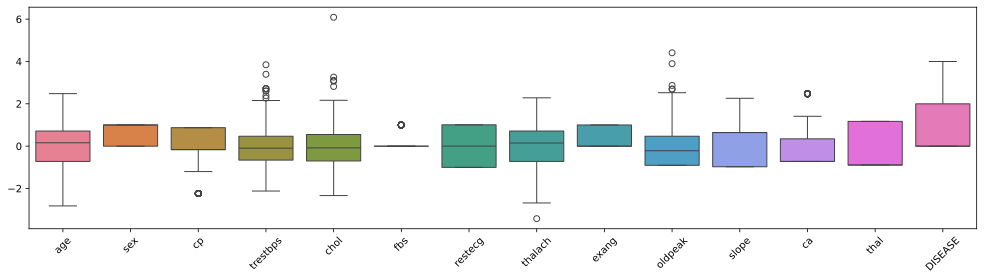

In [550]:
#check the distribution again
fig,ax=plt.subplots(1,figsize=(17,4))
ax=sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [551]:
#count of all unique type of 'DISEASE'
data['DISEASE'].value_counts()

,count
DISEASE,
0,160
1,54
2,35
3,35
4,13


In [552]:
#re_code events to 0 (absent) and 1 (disease)
data['DISEASE'][data['DISEASE']>0]=1



<ipython-input-552-a12ec31ff27c>:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['DISEASE'][data['DISEASE']>0]=1
<ipython-input-552-a12ec31ff27c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

Re-organize the data:train/test in DataLoaders

In [553]:
#convert form pandas dataframe to tensor
dataT=torch.tensor(data[data.keys().drop('DISEASE')].values).float()
labels=torch.tensor(data['DISEASE'].values).long()
print(dataT.shape)
print(labels.shape)
#we'll actually need the labels to be a 'matrix'
labels=labels[:,None]
print(labels.shape)


torch.Size([297, 13])
torch.Size([297])
torch.Size([297, 1])


In [554]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=50)

# then convert them into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [555]:

# check sizes of data batches
for X,y in train_loader:
  print(X.shape,  y.shape)

torch.Size([32, 13]) torch.Size([32, 1])
torch.Size([32, 13]) torch.Size([32, 1])
torch.Size([32, 13]) torch.Size([32, 1])
torch.Size([32, 13]) torch.Size([32, 1])
torch.Size([32, 13]) torch.Size([32, 1])
torch.Size([32, 13]) torch.Size([32, 1])
torch.Size([32, 13]) torch.Size([32, 1])


Create a class for the DL model

In [556]:
# create a class for the model
class theNet(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(13,64)

    ### hidden layers
    self.fc1 = nn.Linear(64,64)
    self.fc2 = nn.Linear(64,16)

    ### output layer
    self.output = nn.Linear(16,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) ) # fully connected
    x = F.relu( self.fc2(x) )
    return self.output(x)

In [557]:
# a function that trains the model

# global parameter
numepochs = 5000

def trainTheModel():
  # check if the model has parameters
  if not list(net.parameters()):
      raise ValueError("Model does not have any parameters!")

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(net.parameters(),lr=.0001)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []
   # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat =net(X)
      loss = lossfun(yHat,y.float())

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)
    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

In [558]:
# create and train a model
net = theNet()
trainAcc,testAcc,losses = trainTheModel()

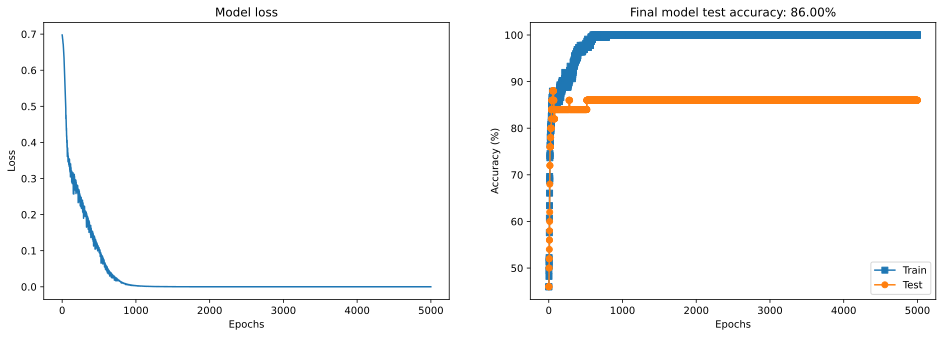

In [559]:
fig,ax = plt.subplots(1,2,figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()